# Chapter 10: Application of Image Processing in Medical Imaging and Remote Sensing

## Problems

1.  **Medical Image Processing**
  
    1. **COVID19** Detection from Radiographs with `Covid-Net` with `tensorflow`      
    2. Prostate image segmentation with `nnUNet` with Medical Decathlon dataset      
    3. Binary Semantic Segmentation of Brain Tumors using `UNet` with `pytorch`
  
2.  **Computer Vision / Image Processing in Remote Sensing**      

    1. Segmentation of `FloodNet` images using `VGG-UNet` with `keras_segmentation`       
    2. **Landcover** Classification with `fastai` `ResNet101` with `EuroSAT` dataset      
    3. **Satellite** Image Segmentation using `fastai` and `wandb` with `FloodNet` dataset

## Problem 1: Medical Image Processing

## 1.1 COVID19 Detection from Radiographs with `Covid-Net` with `tensorflow`

In [ ]:
# run in google colab
import os
import cv2
import numpy as np
#!pip install tensorflow==1.15
import tensorflow as tf
import matplotlib.pyplot as plt
#!pip install gdown

**Downloading the Dataset**

The dataset used in this example is from `Kaggle`'s `COVIDx-CT` dataset. This dataset includes CT scans labeled as Normal, Pneumonia, or COVID-19, making it a suitable choice for training and testing a model designed to detect COVID-19 from radiographs. The dataset can be downloaded using the `Kaggle` API, as shown in the next code snippet (uncomment to run).

In [ ]:
#! pip install kaggle
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download hgunraj/covidxct
#!unzip covidxct -d covidxct
#%cd kaggle/input/covidxct/
#! unzip val_COVIDx_CT-2A.txt.zip
#% cd ../

**Downloading the Pretrained Model**

To save time and computational resources, we use a pretrained model called COVID-Net CT-2 S. The model files are hosted on Google Drive and can be downloaded using their respective IDs.

In [ ]:
# Model name
MODEL_NAME = 'COVID-Net CT-2 S'

# Model location
MODEL_DIR = 'kaggle'
META_NAME = 'model.meta'
CKPT_NAME = 'model'

# Model IDs in Google Drive
MODEL_IDS = {
    'COVID-Net CT-2 L': (
        '1YQxVRYJ37nPSCtjUU9WWlXWRWYvZkKPl',
        '1EgelTN_fyku2m2fALqpJvfjkuQ7Wqqdg',
        '12BhWk_KiQ-hX--Qb7ASdPQTUOfOPccQE'),
    'COVID-Net CT-2 S': (
        '1zKTSxAhRrFhJxUnCcAf73WEZ7OcqvMre',
        '1CSYekjpU1qYXxuOkjL0fBuzBIkvFXAqw',
        '12uiQc5QePuqg2ErRF8llrL1vD9aFIiiJ')
}

#!gdown --id {MODEL_IDS[MODEL_NAME][0]}
#!gdown --id {MODEL_IDS[MODEL_NAME][1]}
#!gdown --id {MODEL_IDS[MODEL_NAME][2]}

In [ ]:
def load_graph(meta_file):
    graph = tf.Graph()
    with graph.as_default():
        # Create session and load model
        sess = create_session()
        # Load meta file
        print('Loading meta graph from ' + meta_file)
        saver = tf.train.import_meta_graph(meta_file, clear_devices=True)
    return graph, sess, saver

def create_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    return sess

In [ ]:
def load_ckpt(ckpt, sess, saver):
    # Load weights
    if ckpt is not None:
        print('Loading weights from ' + ckpt)
        saver.restore(sess, ckpt)

In [ ]:
# Data location
IMAGE_DIR = 'kaggle/input/covidxct/2A_images'
LABEL_FILE = 'kaggle/input/covidxct/val_COVIDx_CT-2A.txt'
#LABEL_FILE = 'kaggle/input/covidxct/train_COVIDx_CT-2A.txt'

# Tensor names
IMAGE_INPUT_TENSOR = 'Placeholder:0'
TRAINING_PH_TENSOR = 'is_training:0'
FINAL_CONV_TENSOR = 'resnet_model/block_layer4:0'
CLASS_PRED_TENSOR = 'ArgMax:0'
CLASS_PROB_TENSOR = 'softmax_tensor:0'
LOGITS_TENSOR = 'resnet_model/final_dense:0'

# Class names, in order of index
CLASS_NAMES = ('Normal', 'Pneumonia', 'COVID-19')

In [ ]:
# Create full paths
meta_file = os.path.join(MODEL_DIR, META_NAME)
ckpt = os.path.join(MODEL_DIR, CKPT_NAME)

# Load metagraph and create session
graph, sess, saver = load_graph(meta_file)

# Load checkpoint
with graph.as_default():
    load_ckpt(ckpt, sess, saver)

In [ ]:
def load_and_preprocess(image_file, bbox=None, width=512, height=512):
    # Load and crop image
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    if bbox is not None:
        image = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image = cv2.resize(image, (width, height), cv2.INTER_CUBIC)
    # Convert to float in range [0, 1] and stack to 3-channel
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(np.stack((image, image, image), axis=-1), axis=0)    
    return image

In [ ]:
def load_labels(label_file):
    fnames, classes, bboxes = [], [], []
    with open(label_file, 'r') as f:
        for line in f.readlines():
            fname, cls, xmin, ymin, xmax, ymax = line.strip('\n').split()
            fnames.append(fname)
            classes.append(int(cls))
            bboxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))
    return fnames, classes, bboxes

In [ ]:
idx = 0
image_file = os.path.join(IMAGE_DIR, filenames[idx])
cls, bbox = classes[idx], bboxes[idx]
image = load_and_preprocess(image_file, bbox)
filenames, classes, bboxes = load_labels(LABEL_FILE)

In [ ]:
def run_inference(graph, sess, images, batch_size=1):
    # Create feed dict
    feed_dict = {TRAINING_PH_TENSOR: False}
    # Run inference
    with graph.as_default():
        classes, confidences = [], []
        num_batches = int(np.ceil(images.shape[0]/batch_size))
        for i in range(num_batches):
            # Get batch and add it to the feed dict
            feed_dict[IMAGE_INPUT_TENSOR] = images[i*batch_size:(i + 1)*batch_size, ...]
            # Run images through model
            preds, probs = sess.run([CLASS_PRED_TENSOR, CLASS_PROB_TENSOR], feed_dict=feed_dict)
            # Add results to list
            classes.append(preds)
            confidences.append(probs)
    classes = np.concatenate(classes, axis=0)
    confidences = np.concatenate(confidences, axis=0)
    return classes, confidences

In [ ]:
def make_gradcam_graph(graph):
    with graph.as_default():
        # Get required tensors
        final_conv = graph.get_tensor_by_name(FINAL_CONV_TENSOR)
        logits = graph.get_tensor_by_name(LOGITS_TENSOR)
        preds = graph.get_tensor_by_name(CLASS_PRED_TENSOR)
        # Get gradient
        top_class_logits = logits[0, preds[0]]
        grads = tf.gradients(top_class_logits, final_conv)[0]
        # Comute per-channel average gradient
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))        
    return final_conv, pooled_grads

In [ ]:
def run_gradcam(final_conv, pooled_grads, sess, image):
    with graph.as_default():
        # Run model to compute activations, gradients, predictions, and confidences
        final_conv_out, pooled_grads_out, class_pred, class_prob = sess.run(
            [final_conv, pooled_grads, CLASS_PRED_TENSOR, CLASS_PROB_TENSOR],
            feed_dict={IMAGE_INPUT_TENSOR: image, TRAINING_PH_TENSOR: False})
        final_conv_out = final_conv_out[0]
        class_pred = class_pred[0]
        class_prob = class_prob[0, class_pred]        
        # Compute heatmap as gradient-weighted mean of activations
        for i in range(pooled_grads_out.shape[0]):
            final_conv_out[..., i] *= pooled_grads_out[i]
        heatmap = np.mean(final_conv_out, axis=-1)
        # Convert to [0, 1] range
        heatmap = np.maximum(heatmap, 0)/np.max(heatmap)        
        # Resize to image dimensions
        heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))        
    return heatmap, class_pred, class_prob

In [ ]:
final_conv, pooled_grads = make_gradcam_graph(graph)
heatmap, class_pred, class_prob = run_gradcam(final_conv, pooled_grads, sess, image)

In [ ]:
# Show image
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
plt.subplots_adjust(0,0,1,0.9,0.05,0.05)
plt.subplots_adjust(hspace=0.01)
ax[0].imshow(image[0]), ax[0].axis('off'), ax[0].set_title('input CT image', size=10)
ax[1].imshow(image[0]), ax[1].axis('off'), ax[1].set_title('Covid-Net CT classification', size=10)
ax[1].imshow(heatmap, cmap='jet', alpha=0.4) #nipy_spectral
plt.suptitle('Predicted Class: {} ({:.3f} confidence), True Class: {}'.format(CLASS_NAMES[class_pred], class_prob, CLASS_NAMES[cls]), size=12)
print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. '
    'You should check with your local authorities for '
    'the latest advice on seeking medical assistance.')
plt.show()

![](images/Img_06_17.png)

## 1.2 Prostate image segmentation with `nnUNet` with Medical Decathlon dataset

In [ ]:
# run in colab
#! pip install nnunet
import nibabel as nib
from glob import glob
from skimage import color 
import matplotlib.pylab as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
!tar xvf drive/MyDrive/Task05_Prostate.tar

In [ ]:
!nnUNet_convert_decathlon_task -i Task05_Prostate
!nnUNet_download_pretrained_model Task005_Prostate
!nnUNet_print_pretrained_model_info Task005_Prostate
!nnUNet_predict -i $nnUNet_raw_data_base/nnUNet_raw_data/Task005_Prostate/imagesTs/ -o output_directory -t 5 -m 3d_fullres

In [ ]:
nifiles = glob('Task05_Prostate/imagesTs/*.nii.gz')
nifiles_seg = glob('output_directory/*.nii.gz')
i, j = 1, 10
nifti = nib.load(nifiles[i]).get_fdata()
nifti_seg = nib.load(nifiles_seg[i]).get_fdata()
#print(nifti.shape)
plt.figure(figsize=(20,7))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
plt.subplot(131), plt.imshow(nifti[...,j,0], cmap='bone'), plt.axis('off'), plt.title('Prostate input 0', size=20)
plt.subplot(132), plt.imshow(nifti[...,j,1], cmap='bone'), plt.axis('off'), plt.title('Prostate input 1', size=20)
plt.subplot(133)
plt.imshow(color.label2rgb(nifti_seg[...,j], nifti[...,j,0] / nifti[...,j,0].max(), \
                           colors=[(255,0,0),(0,0,255),(0,255,0)],alpha=0.01, bg_label=0, bg_color=None))
plt.axis('off'), plt.title('Segmented output with UNet', size=20)
plt.show()

If you run the above code snippet, you should obtain a figure like the following one, with the input image channels ($0$ and $1$), along with the overlayed output color-coded segmentation labels, side-by-side.

![](images/Img_06_16.png)

## 1.3  Binary Semantic Segmentation of Brain Tumors using `UNet` with `pytorch`


![](images/unet_arch.png)

In [ ]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

import numpy as np
from PIL import Image
from torchvision import transforms
from glob import glob

inputs, pred_masks = [], []

for f in glob('images/brain_mri/*.tif'):

    input_image = Image.open(f).convert('RGB')
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize,
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model = model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)
        
    in_img = np.array(input_image)
    in_img = in_img / in_img.max()
    pred_mask = gray2rgb(torch.round(output[0]).squeeze().cpu().numpy())
    
    inputs.append(in_img)
    pred_masks.append(pred_mask)

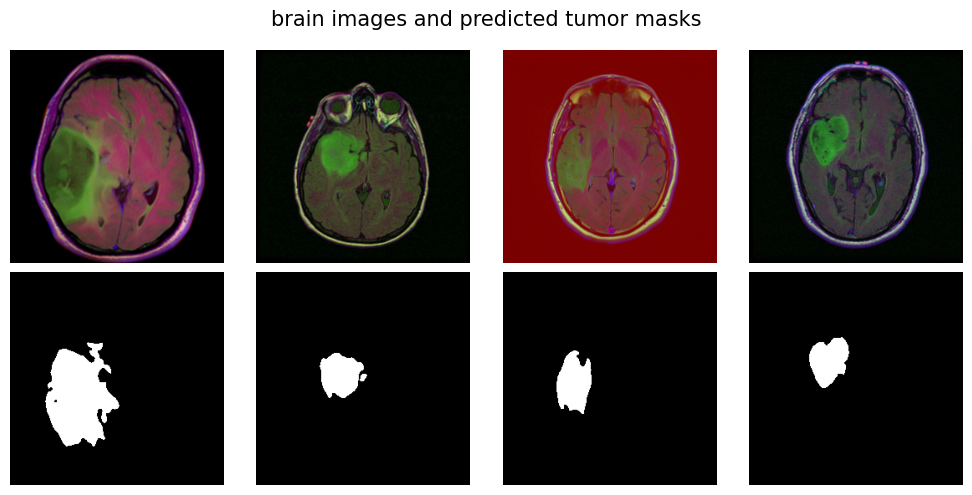

In [49]:
import matplotlib.pylab as plt
import numpy as np
from skimage.color import gray2rgb
plt.figure(figsize=(10,5))
for i in range(len(inputs)):
    plt.subplot(2,4,i+1), plt.imshow(inputs[i]), plt.axis('off')
    plt.subplot(2,4,i+5), plt.imshow(pred_masks[i]), plt.axis('off')        
plt.suptitle('brain images and predicted tumor masks', size=15)
plt.tight_layout()
plt.show()

## Problem 2: Computer Vision / Image Processing in Remote Sensing

## 2.1 Segmentation of `FloodNet` images using `VGG-UNet` with the library `keras_segmentation`

In [ ]:
# run in colab
import numpy as np
import matplotlib.pylab as plt
from skimage.io import imread
from skimage.color import label2rgb
import os

#!pip install keras_segmentation
from keras_segmentation.models.unet import vgg_unet

RESIZE = (512,512)
temp_root = "/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1" 
local_root = "/content/512_Images"

def resize_and_save(path, resize=RESIZE, samples='all'):
  if len(os.listdir(os.path.join(local_root, path))) == 0:
    print(f"{path} --> Saving...\n")
    if samples == 'all':
      samples = len(os.listdir(os.path.join(temp_root, path)))
    for img_name in tqdm(os.listdir(os.path.join(temp_root, path))[:samples]):
      img = cv2.imread(os.path.join(temp_root, path, img_name))
      img = cv2.resize(img, RESIZE)
      cv2.imwrite(os.path.join(local_root, path, img_name), img)
  else:
    print(f"{path} --> images are already saved")

os.makedirs("/content/512_Images/Train/Labeled/Flooded/image", exist_ok=True)
os.makedirs("/content/512_Images/Train/Labeled/Non-Flooded/image", exist_ok=True)
os.makedirs("/content/512_Images/Train/Labeled/Flooded/mask", exist_ok=True)
os.makedirs("/content/512_Images/Train/Labeled/Non-Flooded/mask", exist_ok=True)
os.makedirs("/content/512_Images/Train/Unlabeled/image", exist_ok=True)
os.makedirs("/content/512_Images/Test/image", exist_ok=True)
resize_and_save("Train/Labeled/Flooded/image")
resize_and_save("Train/Labeled/Non-Flooded/image")
resize_and_save("Train/Labeled/Flooded/mask")
resize_and_save("Train/Labeled/Non-Flooded/mask")
resize_and_save("Train/Unlabeled/image")
resize_and_save("Test/image")
#resize_and_save("Train/Unlabeled/image", samples=100)      

In [ ]:
model = vgg_unet(n_classes=10,  input_height=512, input_width=512)
model.train(
    train_images =  "512_Images/Train/Labeled/All/image",
    train_annotations = "512_Images/Train/Labeled/All/mask",
    #validate=True,
    #val_images =  "512_Images/Val/Labeled/All/image",
    #val_annotations = "512_Images/Val/Labeled/All/mask",
    checkpoints_path = "models/vgg_unet_1", 
    epochs=5
)

In [ ]:
folder = '512_Images/Test/image'
for f in os.listdir(folder):
  out = model.predict_segmentation(out_fname=os.path.join('out/', f))
for f in os.listdir(folder):
  test_img = imread(os.path.join('512_Images/Test/image/', f))
  test_mask = imread(os.path.join('out/', f), 1)
  test_img = test_img / test_img.max()
  test_mask = test_mask / test_mask.max()
  print(f, img_san.shape, mask_san.shape, mask_san.max(), img_san.max(), len(np.unique(mask_san)))
  if len(np.unique(mask_san)) > 1: # and img_san.shape[:2] == mask_san.shape:
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
    plt.subplot(131), plt.imshow(img_san), plt.axis('off'), plt.title('input (test)', size=20)
    plt.subplot(132), plt.imshow(mask_san, cmap='jet'), plt.axis('off'), plt.title('predicted segmentation mask\n with PSP-UNet (trained only for 5 epochs)', size=20) #cividis
    plt.subplot(133), plt.imshow(label2rgb(mask_san, img_san)), plt.axis('off'), plt.title('overlayed mask', size=20)
    plt.show()

If you run the above code snippet, you should obtain a figure like the following one:

![](images/Img_06_26.png)

## 2.2 Landcover Classification with `fastai` `ResNet101` with `EuroSAT` dataset

### Residual Networks (ResNet)

In [ ]:
# run in colab
# import the required libraries  
%reload_ext autoreload
%autoreload 2
from fastai.vision import *  # import the vision module
from fastai.metrics import error_rate  # import our evaluation metric
import zipfile # import module to unzip the data
import urllib.request 
import os # import module to access file paths

In [ ]:
url = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
urllib.request.urlretrieve(url,"2750.zip")
zf = zipfile.ZipFile("2750.zip")
zf.extractall()

In [ ]:
data_path = os.getcwd()
path = datapath4file(data_path+'/2750')
tfms = get_transforms(flip_vert=True, max_warp = 0.)
data = ImageDataBunch.from_folder(path, train = ".", 
                                  valid_pct=0.2, 
                                  ds_tfms = tfms, 
                                  size=224, bs = 32).normalize(imagenet_stats)
#data.show_batch(rows=5, figsize=(15,15))
learn = cnn_learner(data, models.resnet101, metrics=error_rate)
#print(learn.summary())

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
#Min numerical gradient: 1.20E-03
#Min loss divided by 10: 6.92E-03

Running the abobe lines of code generates a figure like the following one:

![](images/Img_06_27.png)

In [ ]:
lr = 1.20E-03
learn.fit_one_cycle(6, slice(lr))

![](images/Img_06_28.png)

In [ ]:
learn.freeze()
learn.lr_find()
#learn.recorder.plot()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
# True

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

![](images/Img_06_29.png)

In [ ]:
interp.most_confused(min_val=5)
# [('PermanentCrop', 'HerbaceousVegetation', 11),
# ('River', 'Highway', 9),
# ('AnnualCrop', 'PermanentCrop', 8),
# ('PermanentCrop', 'AnnualCrop', 5)]

In [ ]:
learn.export()
learn.show_results(rows=6, figsize=(15,15))

Run the above code snippet to obtain a figure like the following one:

![](images/Img_06_30.png)

## 2.3 Satellite Image Segmentation using `fastai` and `wandb` with `SN7` dataset 

In [ ]:
# run in colab
import os
#!pip install fastcore==1.3.19 fastai==2.2.5 rasterio geopandas shapely wandb -Uqq
from fastai.vision.all import *
from tqdm import tqdm
from pdb import set_trace
from pprint import pprint

import wandb
from fastai.callback.wandb import *
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
warnings.filterwarnings("ignore")

path = Path('/content/train')
Path.BASE_PATH = path

In [ ]:
text = '''
[default]
aws_access_key_id = XXXXXXXXXXXXXX
aws_secret_access_key = XXXXXXXXXXXXXXXXX
'''
path = "/content/config/awscli.ini"
with open(path, 'w') as f:
   f.write(text)
!cat /content/config/awscli.ini

!export AWS_SHARED_CREDENTIALS_FILE=/content/drive/My\ Drive/config/awscli.ini
path = "/content/config/awscli.ini"
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

In [ ]:
!pip install awscli

!aws s3 cp s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_train.tar.gz .
!aws s3 cp s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_train_csvs.tar.gz . 
!aws s3 cp s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/SN7_buildings_test_public.tar.gz . 

!mv SN7_buildings_train.tar.gz drive/MyDrive
!tar xvf SN7_buildings_train.tar.gz
!tar xvf SN7_buildings_train_csvs.tar.gz
!tar xvf SN7_buildings_test_public.tar.gz

In [ ]:
try:
  print(torch.cuda.get_device_properties(0))
except:
  print("No CUDA device available.")

In [ ]:
BATCH_SIZE = 12 # 3 for xresnet50, 12 for xresnet34 with Tesla P100 (16GB)
TILES_PER_SCENE = 16
ARCHITECTURE = xresnet34
EPOCHS = 40
CLASS_WEIGHTS = [0.25,0.75]
LR_MAX = 3e-4
ENCODER_FACTOR = 10
CODES = ['Land','Building']

# Weights and Biases config
config_dictionary = dict(
    bs=BATCH_SIZE,
    tiles_per_scene=TILES_PER_SCENE,
    architecture = str(ARCHITECTURE),
    epochs = EPOCHS,
    class_weights = CLASS_WEIGHTS,
    lr_max = LR_MAX,
    encoder_factor = ENCODER_FACTOR
)

In [ ]:
def generate_mask(raster_path, shape_path, output_path=None, file_name=None):    
    
    #load raster    
    with rasterio.open(raster_path, "r") as src:
        raster_img = src.read()
        raster_meta = src.meta
    #load o shapefile ou GeoJson
    train_df = gpd.read_file(shape_path)
    #Verify crs
    if train_df.crs != src.crs:
        print(" Raster crs : {}, Vector crs : {}.\n Convert vector and raster to the same CRS.".format(src.crs,train_df.crs))
        
    #Function that generates the mask
    def poly_from_utm(polygon, transform):
        poly_pts = []
        poly = cascaded_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append(~transform * tuple(i))
        new_poly = Polygon(poly_pts)
        return new_poly
        
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in train_df.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly = poly_from_utm(row['geometry'], src.meta['transform'])
            poly_shp.append(poly)
        else:
            for p in row['geometry']:
                poly = poly_from_utm(p, src.meta['transform'])
                poly_shp.append(poly)

    if len(poly_shp) > 0:
      mask = rasterize(shapes=poly_shp, out_shape=im_size)
    else:
      mask = np.zeros(im_size)
    
    # Save or show mask
    mask = mask.astype("uint8")    
    bin_mask_meta = src.meta.copy()
    bin_mask_meta.update({'count': 1})
    if (output_path != None and file_name != None):
      os.chdir(output_path)
      with rasterio.open(file_name, 'w', **bin_mask_meta) as dst:
          dst.write(mask * 255, 1)
    else: 
      return mask

def save_masks():
  for scene in tqdm(path.ls().sorted()):
    for img in (scene/'images_masked').ls():
      shapes = scene/'labels_match'/(img.name[:-4]+'_Buildings.geojson')
      if not os.path.exists(scene/'binary_mask'/img.name):
        if not os.path.exists(scene/'binary_mask'):
          os.makedirs(scene/'binary_mask')
        generate_mask(img, shapes, scene/'binary_mask', img.name)
        
save_masks()

In [ ]:
def get_masked_images(path:Path, n=1)->list:
  files = []
  for folder in path.ls():
    files.extend(get_image_files(path=folder, folders='images_masked')[:n])
  return files

masked_images = get_masked_images(path, 1)
#len(masked_images)

sample_scene = (path/'L15-0683E-1006N_2732_4164_13')
#pprint(list(sample_scene.ls()))

If you plot the above sample scene, along with its ground-truth mask side-by-side, you should get a figure like the next one:

![](images/Img_06_31.png)

In [ ]:
def cut_tiles(tile_size:int):
  "Cuts the large images and masks into equal tiles and saves them to disk"
  masked_images = get_masked_images(path, 5)
  for fn in tqdm(masked_images):
    scene = fn.parent.parent
    if not os.path.exists(scene/'img_tiles'):
      os.makedirs(scene/'img_tiles')
    if not os.path.exists(scene/'mask_tiles'):
      os.makedirs(scene/'mask_tiles')
    # Create mask for current image
    img = np.array(PILImage.create(fn))
    msk_fn = str(fn).replace('images_masked', 'binary_mask')
    msk = np.array(PILMask.create(msk_fn))
    x, y, _ = img.shape
    # Cut tiles and save them
    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = img[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        msk_tile = msk[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{scene}/img_tiles/{fn.name[:-4]}_{i}_{j}.png')
        Image.fromarray(msk_tile).save(f'{scene}/mask_tiles/{fn.name[:-4]}_{i}_{j}.png')
        
TILE_SIZE = 255
cut_tiles(TILE_SIZE)

If you run the above code you should obtain smaller tiles cut from the scenes, as shown in the next figure.

![](images/Img_06_33.png)

In [ ]:
tfms = [Dihedral(0.5),              # Horizontal and vertical flip
        Rotate(max_deg=180, p=0.9), # Rotation in any direction possible
        Brightness(0.2, p=0.75),
        Contrast(0.2),
        Saturation(0.2),
        Normalize.from_stats(*imagenet_stats)]

tiles = DataBlock(
      blocks = (ImageBlock(), MaskBlock(codes=CODES)), # Independent variable is Image, dependent variable is Mask
      get_items = get_undersampled_tiles,             # Collect undersampled tiles
      get_y = get_y,                                  # Get dependent variable: mask
      splitter = FuncSplitter(valid_split),           # Split into training and validation set
      batch_tfms = tfms                               # Transforms on GPU: augmentation, normalization
    )                              

dls = tiles.dataloaders(path, bs=BATCH_SIZE)
dls.vocab = CODES

In [ ]:
weights = Tensor(CLASS_WEIGHTS).cuda()
loss_func = CrossEntropyLossFlat(axis=1, weight=weights)

learn = unet_learner(dls,                                 # DataLoaders
                     ARCHITECTURE,                        # xResNet34
                     loss_func = loss_func,               # Weighted cross entropy loss
                     opt_func = Adam,                     # Adam optimizer
                     metrics = [Dice(), foreground_acc],  # Custom metrics
                     self_attention = False,
                     cbs = [SaveModelCallback(
                              monitor='dice',
                              comp=np.greater,
                              fname='best-model'
                            )]
                     )

In [ ]:
#!pip install wandb --upgrade
# Log in to your W&B account
wandb.login()
wandb.init(project="spacenet7", config=config_dictionary)
learn.unfreeze()
learn.fit_one_cycle(
    EPOCHS,
    lr_max=slice(lr_max/ENCODER_FACTOR, lr_max),
    cbs=[WandbCallback()]
)
wandb.finish()

In [ ]:
probs,targets,preds,losses = learn.get_preds(dl=dls.valid, with_loss=True, with_decoded=True, act=None)

If you plot the original image and the `fastai` predicted segmentation masks side-by-side for the sample image above, you should obtain a figure like the following one:

![](images/Img_06_34.png)

## Questions

1. Convert medical images in **DICOM** format to **NIfTI** format (hint: use the library `dicom2nifti`).

2. Brain Tumor Detection using **transfer learning** with **Mask R-CNN** with Medical Decathlon dataset: Download the dataset `Task01_BrainTumour.tar` from the **Gdrive** from  http://medicaldecathlon.com/. Refer to the problem 11 from the last chapter (chapter 5) (Custom Object Detection and Instance Segmentation with Mask R-CNN). Select (e.g., $2000$ images) randomly from the training dataset along with the labels and create annotation jsons from the labels (e.g., define a function to create annotations and bounding boxes), you should obtain annotated images as shown in the next figure.

![](images/Img_06_18.png)

Partition the annotated images into two sets: `training` and `validation`. Use the function `load_image_dataset()` to load the train and validation images along with annotations. There should be only $1$ class corresponding to `'Tumor'`, that we want to detect. If you use `display_image_samples()` on an image with annotation you should obtain a figure like the following one:

![](images/Img_06_19.png)

Train the model (e.g., for $10$ epochs) on the annotated images, by freezing all the layers except the head layers. After training is over, use the model for inference, to predict the tumor region (along with the bounding box) of a (held-out) `test` image and overlay on top the actual label (use the `color_spalsh()` function), You should obtain a figure like the following, for the given test image:

![](images/Img_06_20.png)

3. Implement a function to compute the **IOU** (**Intersection over Union (IoU)**) of the model on the test images, from the previous question, to evaluate the model. Remember that the IoU measures the overlap between the predicted bounding box and the ground truth bounding box. It is defined as the area of overlap divided by the area of union between the predicted and ground truth boxes.

## References

1. https://arxiv.org/pdf/1610.02391
2. https://www.nature.com/articles/s41592-020-01008-z
3. https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28
4. http://medicaldecathlon.com/
5. https://www.youtube.com/watch?v=bU-KxXNUQ80
6. https://github.com/divamgupta/image-segmentation-keras
7. https://github.com/chrieke/awesome-satellite-imagery-datasets
8. https://www.youtube.com/shorts/UWFxyZYHIio
9. https://www.youtube.com/watch?v=pFKARAl-wzA
10. https://www.youtube.com/watch?v=AwjAp_6K958
11. https://www.youtube.com/watch?v=J87VNteZ6RI